QUANTUM MACHINE LEARNING WITH QISKIT - FIXED VERSION
Comparing Quantum Feature Maps vs Classical PCA
Loading and preprocessing data...
Dataset shape - Training: (105, 2), Test: (45, 2)
Creating quantum feature mapper...
Encoding training data into quantum states...


Encoding test data into quantum states...
Quantum embedding shape - Training: (105, 4)
Applying PCA for baseline comparison...
Using 2 PCA components (max possible: 2)
PCA embedding shape - Training: (105, 2)
Training quantum classifier...
Training PCA baseline classifier...

Results:
Quantum embedding accuracy: 0.7333
PCA baseline accuracy: 0.8000
Applying t-SNE to quantum embeddings for visualization...


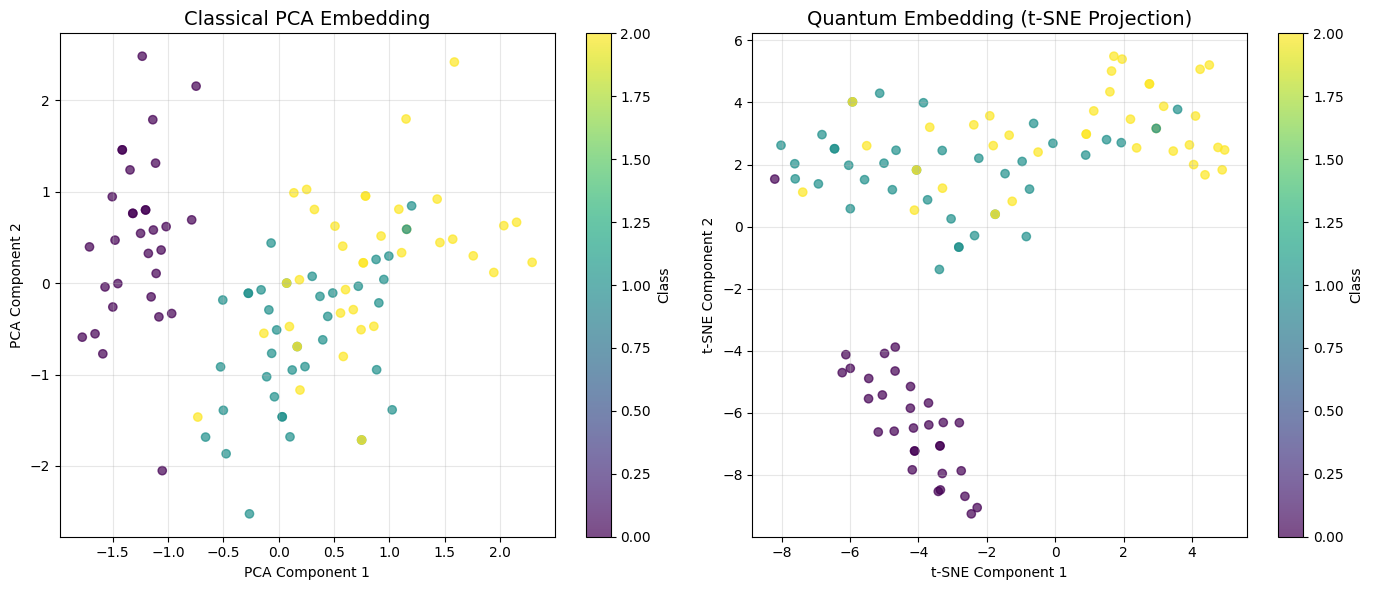


EXPERIMENT SUMMARY
Quantum Feature Map Accuracy: 0.7333
Classical PCA Accuracy:       0.8000

→ PCA outperforms quantum approach by: 0.0667

Note: Results may vary due to the small dataset size and
the simplicity of the quantum feature map used.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator


class QuantumFeatureMapper:
    """Handles quantum feature encoding and data transformation."""
    
    def __init__(self, n_features):
        """Initialize quantum feature mapper with specified number of features."""
        self.n_features = n_features
        self.backend = AerSimulator(method='statevector')
    
    def create_feature_map(self, x):
        """Creates quantum circuit for feature encoding using angle encoding."""
        qc = QuantumCircuit(len(x))
        for i, val in enumerate(x):
            qc.ry(val, i)  # encode each feature as a rotation
        return qc
    
    def encode_dataset(self, X):
        """Encodes classical dataset into quantum statevectors."""
        states = []
        for x in X:
            # Create quantum circuit with feature encoding
            qc = self.create_feature_map(x)
            qc.save_statevector()  # Add instruction to save statevector
            
            # Transpile for backend
            qc_transpiled = transpile(qc, self.backend)
            
            # Execute and get statevector
            job = self.backend.run(qc_transpiled)
            result = job.result()
            state = result.get_statevector()
            
            # Use real part only for classical ML
            states.append(np.real(state))
            
        return np.array(states)


class DataPreprocessor:
    """Handles data loading and preprocessing."""
    
    def __init__(self):
        """Initialize preprocessor with scaler and PCA."""
        self.scaler = StandardScaler()
        self.pca = None  # Will be initialized based on actual data dimensions
    
    def load_and_preprocess_data(self, test_size=0.3, random_state=42):
        """Loads Iris dataset and performs preprocessing."""
        # Load Iris dataset
        iris = load_iris()
        X = iris.data[:, :2]  # Use first 2 features for visualization clarity
        y = iris.target
        
        # Standardize features
        X = self.scaler.fit_transform(X)
        
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        return X_train, X_test, y_train, y_test
    
    def apply_pca(self, X_train, X_test):
        """Applies PCA transformation for baseline comparison - FIXED VERSION."""
        # Determine the maximum number of components we can extract
        n_samples, n_features = X_train.shape
        max_components = min(n_samples, n_features)
        
        # Use the maximum available components (but cap at reasonable number)
        n_components = min(2, max_components)  # Since we only have 2 features
        
        print(f"Using {n_components} PCA components (max possible: {max_components})")
        
        # Initialize PCA with correct number of components
        self.pca = PCA(n_components=n_components)
        
        X_train_pca = self.pca.fit_transform(X_train)
        X_test_pca = self.pca.transform(X_test)
        
        return X_train_pca, X_test_pca


class QuantumMLClassifier:
    """Main class that orchestrates quantum ML classification"""
    
    def __init__(self):
        """Initialize the quantum ML classifier with components."""
        self.preprocessor = DataPreprocessor()
        self.quantum_mapper = None
        self.clf_quantum = SVC(kernel='linear')
        self.clf_pca = SVC(kernel='linear')
    
    def run_experiment(self):
        """Runs the complete quantum ML experiment."""
        print("Loading and preprocessing data...")
        X_train, X_test, y_train, y_test = self.preprocessor.load_and_preprocess_data()
        
        print(f"Dataset shape - Training: {X_train.shape}, Test: {X_test.shape}")
        
        # Initialize quantum mapper
        print("Creating quantum feature mapper...")
        self.quantum_mapper = QuantumFeatureMapper(n_features=X_train.shape[1])
        
        # Quantum encoding
        print("Encoding training data into quantum states...")
        X_train_quantum = self.quantum_mapper.encode_dataset(X_train)
        print("Encoding test data into quantum states...")
        X_test_quantum = self.quantum_mapper.encode_dataset(X_test)
        
        print(f"Quantum embedding shape - Training: {X_train_quantum.shape}")
        
        # Classical PCA baseline
        print("Applying PCA for baseline comparison...")
        X_train_pca, X_test_pca = self.preprocessor.apply_pca(X_train, X_test)
        
        print(f"PCA embedding shape - Training: {X_train_pca.shape}")
        
        # Train classifiers
        print("Training quantum classifier...")
        self.clf_quantum.fit(X_train_quantum, y_train)
        
        print("Training PCA baseline classifier...")
        self.clf_pca.fit(X_train_pca, y_train)
        
        # Make predictions
        y_pred_quantum = self.clf_quantum.predict(X_test_quantum)
        y_pred_pca = self.clf_pca.predict(X_test_pca)
        
        # Calculate accuracies
        quantum_accuracy = accuracy_score(y_test, y_pred_quantum)
        pca_accuracy = accuracy_score(y_test, y_pred_pca)
        
        # Print results
        print(f"\nResults:")
        print(f"Quantum embedding accuracy: {quantum_accuracy:.4f}")
        print(f"PCA baseline accuracy: {pca_accuracy:.4f}")
        
        # Create visualizations
        self._visualize_embeddings(X_train_pca, X_train_quantum, y_train)
        
        return quantum_accuracy, pca_accuracy
    
    def _visualize_embeddings(self, X_train_pca, X_train_quantum, y_train):
        """Creates visualization comparing PCA and quantum embeddings."""
        plt.figure(figsize=(14, 6))
        
        # PCA embedding visualization
        plt.subplot(1, 2, 1)
        scatter_pca = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                                c=y_train, cmap='viridis', alpha=0.7)
        plt.title("Classical PCA Embedding", fontsize=14)
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.colorbar(scatter_pca, label='Class')
        plt.grid(True, alpha=0.3)
        
        # Quantum embedding visualization using t-SNE
        print("Applying t-SNE to quantum embeddings for visualization...")
        perplexity_val = min(30, len(X_train_quantum) - 1)
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val)
        X_train_quantum_tsne = tsne.fit_transform(X_train_quantum)
        
        plt.subplot(1, 2, 2)
        scatter_quantum = plt.scatter(X_train_quantum_tsne[:, 0], X_train_quantum_tsne[:, 1], 
                                    c=y_train, cmap='viridis', alpha=0.7)
        plt.title("Quantum Embedding (t-SNE Projection)", fontsize=14)
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.colorbar(scatter_quantum, label='Class')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


def main():
    """Main function to run the quantum ML experiment."""
    print("=" * 70)
    print("Comparing Quantum Feature Maps vs Classical PCA")
    print("=" * 70)
    
    try:
        # Initialize and run experiment
        qml_classifier = QuantumMLClassifier()
        quantum_acc, pca_acc = qml_classifier.run_experiment()
        
        # Display summary
        print("\n" + "=" * 70)
        print("EXPERIMENT SUMMARY")
        print("=" * 70)
        print(f"Quantum Feature Map Accuracy: {quantum_acc:.4f}")
        print(f"Classical PCA Accuracy:       {pca_acc:.4f}")
        
        improvement = quantum_acc - pca_acc
        if improvement > 0:
            print(f"\n✓ Quantum approach outperforms PCA by: {improvement:.4f}")
        elif improvement < 0:
            print(f"\n→ PCA outperforms quantum approach by: {abs(improvement):.4f}")
        else:
            print(f"\n= Both approaches perform equally well")
            
        print("\nNote: Results may vary due to the small dataset size and")
        print("the simplicity of the quantum feature map used.")
        
    except Exception as e:
        print(f"Error running experiment: {e}")


if __name__ == "__main__":
    main()
